# 🔐 PoketraFinday - Système de Détection de Fraudes

## 📋 Contexte
**Équipe**: Data & Sécurité  
**Mission**: Développer un modèle ML pour détecter les transactions frauduleuses

### Problématique
PoketraFinday est une fintech malgache innovante transformant chaque téléphone en portefeuille électronique. Notre mission est de protéger la plateforme contre les fraudes sophistiquées tout en maintenant une excellente expérience utilisateur.

---

## 📦 1.Importation des Bibliothèques

In [2]:
# Importation des bibliothèques essentielles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Métriques d'évaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, precision_score, recall_score,
    roc_auc_score, roc_curve
)

# Gestion du déséquilibre
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Bibliothèques importées avec succès!")

✅ Bibliothèques importées avec succès!


## 📊 2. Chargement et Exploration Initiale des Données

In [5]:
# Chargement des données
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print("📁 Données chargées:")
print(f"  - Train set: {train_df.shape[0]} transactions, {train_df.shape[1]} colonnes")
print(f"  - Test set: {test_df.shape[0]} transactions, {test_df.shape[1]} colonnes")

📁 Données chargées:
  - Train set: 30000 transactions, 7 colonnes
  - Test set: 10000 transactions, 6 colonnes


In [7]:
# Aperçu des premières lignes
print("\n🔍 Aperçu des données:")
display(train_df.head(10))


🔍 Aperçu des données:


,transaction_id,step,type,amount,customer_id,age,is_fraud
0,38d8cd1a-ab64-48a8-982b-547db096f8a5,421,PAYMENT,311000,C13646530,24,0
1,2440928e-8a4c-4e74-a9c5-6329668be13d,325,PAYMENT,399600,C9452763,25,0
2,973c2a3c-5676-477c-ac30-81334b01e90d,565,PAYMENT,7500,C31260354,38,0
3,5413d0f4-b4f0-406f-bd91-91de1dce573c,511,TRANSFER,94000,C8841991,26,0
4,c9fa99e2-42c8-4dd8-94ba-aa3e44bfdd98,63,CASH_OUT,15000,C3176716,26,0
5,fb3ef0a1-ce2e-4479-a621-f2267c2d697d,468,CASH_OUT,111800,C728995,20,0
6,f06bafef-fe08-4469-ac5b-c334698cf354,706,PAYMENT,37000,C12692187,29,0
7,5cdf85dc-32fe-49c3-a55c-fed0b2ef32d2,602,DEBIT,91500,C26312927,22,0
8,47c2812c-8507-42d0-b608-9c35e886a498,183,CASH_OUT,270000,C3105884,47,0
9,5bae90fc-a546-4b37-aa2b-52534340bb34,373,CASH_OUT,18500,C80405467,22,0


In [9]:
# Informations sur le dataset
print("\n📋 Informations sur le dataset:")
print(train_df.info())
print("\n📊 Statistiques descriptives:")
display(train_df.describe())


📋 Informations sur le dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  30000 non-null  object
 1   step            30000 non-null  int64 
 2   type            30000 non-null  object
 3   amount          30000 non-null  int64 
 4   customer_id     30000 non-null  object
 5   age             30000 non-null  int64 
 6   is_fraud        30000 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 1.6+ MB
None

📊 Statistiques descriptives:


,step,amount,age,is_fraud
count,30000.000000,3.000000e+04,30000.000000,30000.000000
mean,361.139733,1.474855e+05,34.516800,0.019833
std,207.894173,4.114664e+05,16.067294,0.139430
min,0.000000,1.000000e+02,18.000000,0.000000
25%,180.000000,1.750000e+04,23.000000,0.000000
50%,364.000000,4.930000e+04,28.000000,0.000000
75%,541.000000,1.360000e+05,43.000000,0.000000
max,719.000000,1.921400e+07,90.000000,1.000000


In [11]:
# Vérification des valeurs manquantes
print("\n🔍 Valeurs manquantes:")
missing_values = train_df.isnull().sum()
missing_percent = (missing_values / len(train_df)) * 100
missing_df = pd.DataFrame({
    'Colonne': missing_values.index,
    'Valeurs Manquantes': missing_values.values,
    'Pourcentage': missing_percent.values
})
display(missing_df[missing_df['Valeurs Manquantes'] > 0])


🔍 Valeurs manquantes:


,Colonne,Valeurs Manquantes,Pourcentage


## 🎯 3. Analyse Exploratoire des Données (EDA) - Focus sur la Fraude

### 3.1 Distribution de la Variable Cible


🎯 Distribution de la Fraude:
  - Transactions légitimes: 29,405 (98.02%)
  - Transactions frauduleuses: 595 (1.98%)

⚠️ Ratio de déséquilibre: 1:49.4


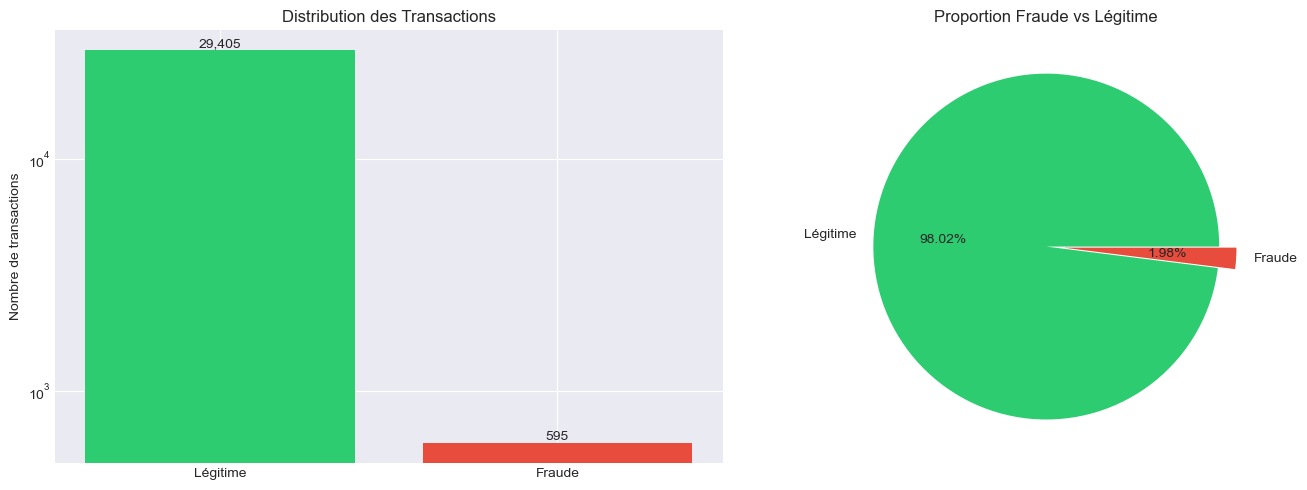

In [15]:
# Distribution de la fraude
fraud_counts = train_df['is_fraud'].value_counts()
fraud_percent = train_df['is_fraud'].value_counts(normalize=True) * 100

print("\n🎯 Distribution de la Fraude:")
print(f"  - Transactions légitimes: {fraud_counts[0]:,} ({fraud_percent[0]:.2f}%)")
print(f"  - Transactions frauduleuses: {fraud_counts[1]:,} ({fraud_percent[1]:.2f}%)")
print(f"\n⚠️ Ratio de déséquilibre: 1:{fraud_counts[0]/fraud_counts[1]:.1f}")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique en barres
axes[0].bar(['Légitime', 'Fraude'], fraud_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_ylabel('Nombre de transactions')
axes[0].set_title('Distribution des Transactions')
axes[0].set_yscale('log')
for i, v in enumerate(fraud_counts.values):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom')

# Graphique en camembert
axes[1].pie(fraud_counts.values, labels=['Légitime', 'Fraude'], 
            autopct='%1.2f%%', colors=['#2ecc71', '#e74c3c'],
            explode=(0, 0.1))
axes[1].set_title('Proportion Fraude vs Légitime')

plt.tight_layout()
plt.show()

### 3.2 Analyse par Type de Transaction


💳 Taux de fraude par type de transaction:


is_fraud,0,1
type,,
CASH_OUT,99.727838,0.272162
DEBIT,99.327505,0.672495
PAYMENT,99.757848,0.242152
TRANSFER,93.541667,6.458333


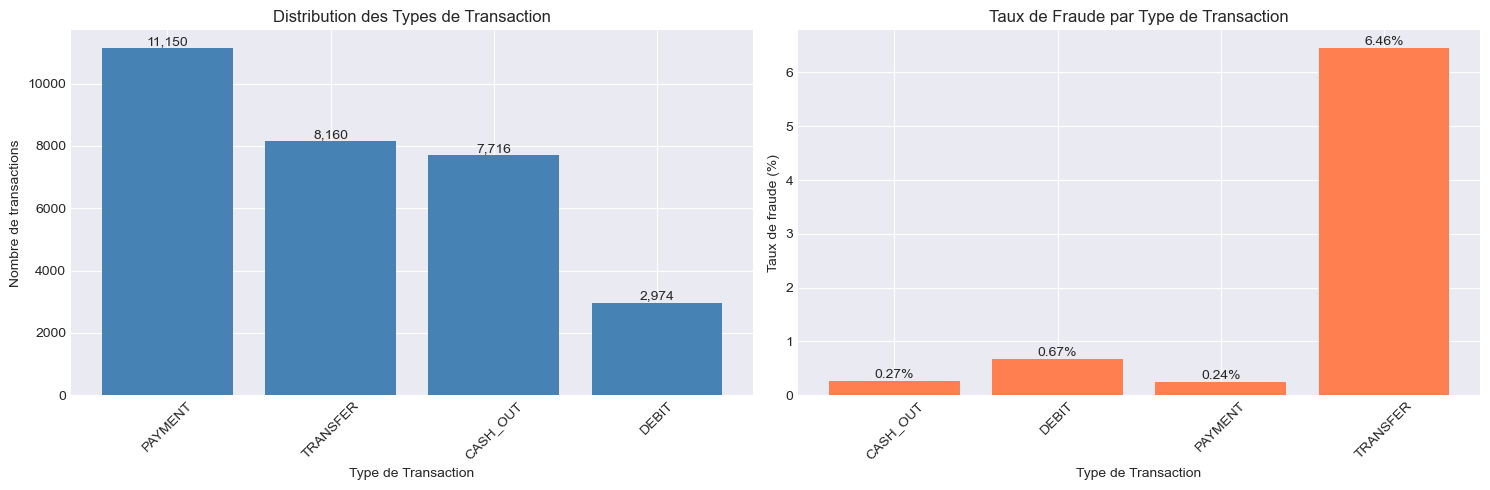

In [18]:
# Types de transactions et fraudes
transaction_fraud = pd.crosstab(train_df['type'], train_df['is_fraud'], normalize='index') * 100

print("\n💳 Taux de fraude par type de transaction:")
display(transaction_fraud)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution des types
type_counts = train_df['type'].value_counts()
axes[0].bar(type_counts.index, type_counts.values, color='steelblue')
axes[0].set_xlabel('Type de Transaction')
axes[0].set_ylabel('Nombre de transactions')
axes[0].set_title('Distribution des Types de Transaction')
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(type_counts.values):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom')

# Taux de fraude par type
fraud_by_type = train_df.groupby('type')['is_fraud'].mean() * 100
axes[1].bar(fraud_by_type.index, fraud_by_type.values, color='coral')
axes[1].set_xlabel('Type de Transaction')
axes[1].set_ylabel('Taux de fraude (%)')
axes[1].set_title('Taux de Fraude par Type de Transaction')
axes[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(fraud_by_type.values):
    axes[1].text(i, v, f'{v:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### 3.3 Analyse des Montants


💰 Statistiques des montants (MGA):


,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,29405.0,140615.514368,3.767579e+05,100.0,17400.0,47500.0,130500.0,19214000.0
1,595.0,486999.831933,1.185774e+06,1100.0,110000.0,155000.0,255000.0,16558000.0


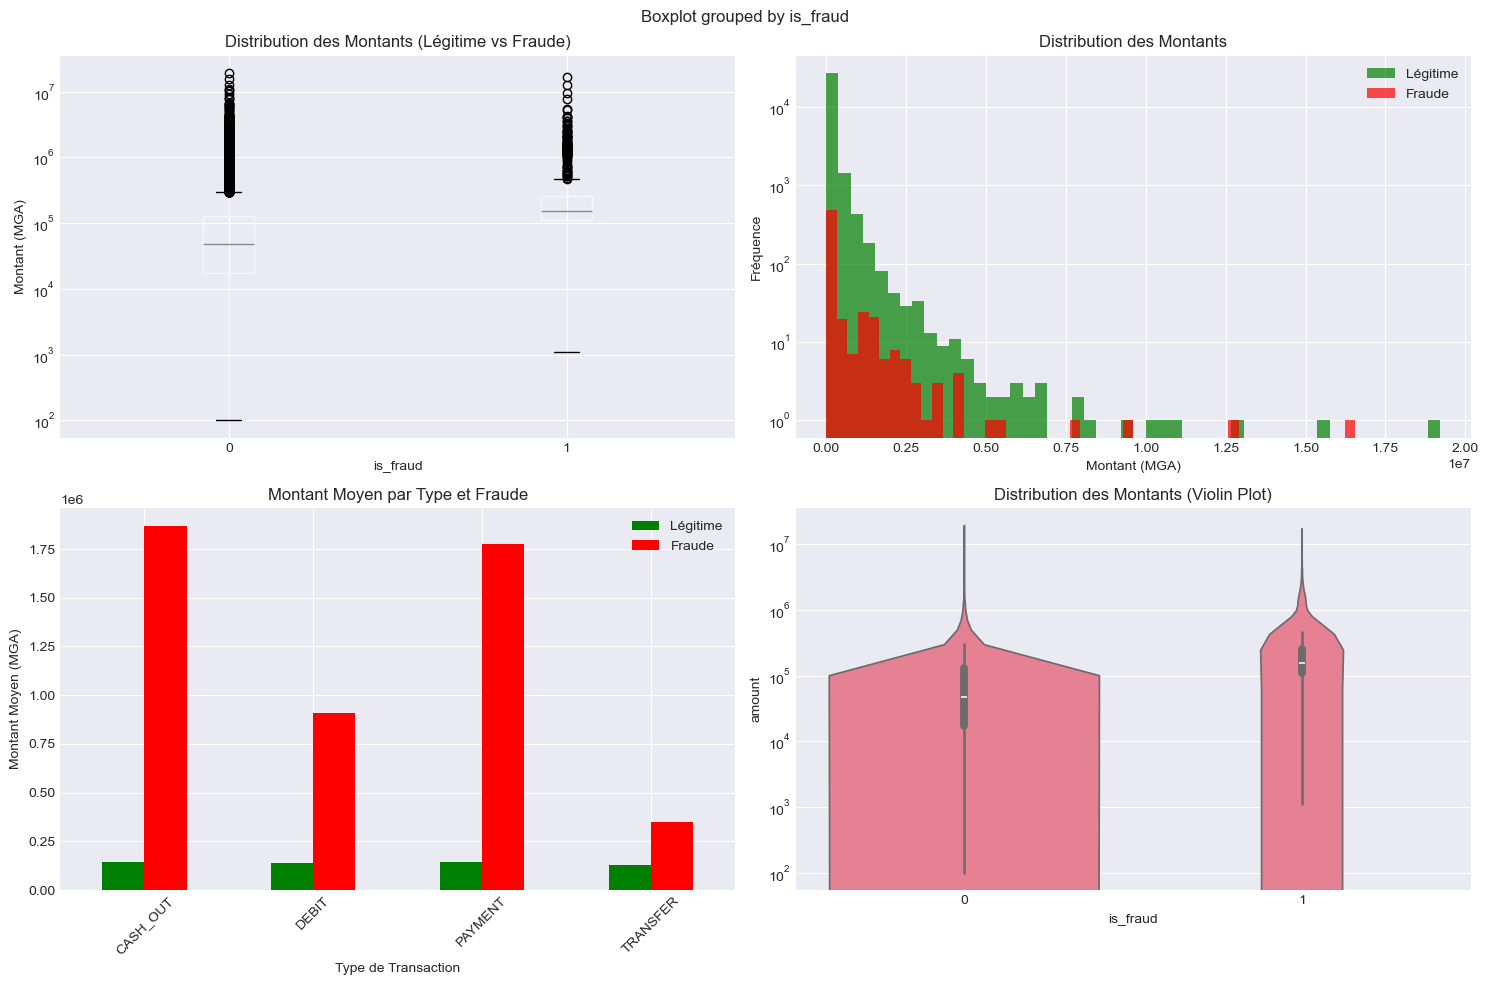

In [21]:
# Statistiques des montants par type de transaction
print("\n💰 Statistiques des montants (MGA):")
amount_stats = train_df.groupby('is_fraud')['amount'].describe()
display(amount_stats)

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Boxplot des montants par fraude
train_df.boxplot(column='amount', by='is_fraud', ax=axes[0, 0])
axes[0, 0].set_title('Distribution des Montants (Légitime vs Fraude)')
axes[0, 0].set_xlabel('is_fraud')
axes[0, 0].set_ylabel('Montant (MGA)')
axes[0, 0].set_yscale('log')

# Distribution des montants
axes[0, 1].hist(train_df[train_df['is_fraud']==0]['amount'], bins=50, alpha=0.7, label='Légitime', color='green')
axes[0, 1].hist(train_df[train_df['is_fraud']==1]['amount'], bins=50, alpha=0.7, label='Fraude', color='red')
axes[0, 1].set_xlabel('Montant (MGA)')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].set_title('Distribution des Montants')
axes[0, 1].set_yscale('log')
axes[0, 1].legend()

# Montant moyen par type de transaction et fraude
mean_amount = train_df.groupby(['type', 'is_fraud'])['amount'].mean().unstack()
mean_amount.plot(kind='bar', ax=axes[1, 0], color=['green', 'red'])
axes[1, 0].set_title('Montant Moyen par Type et Fraude')
axes[1, 0].set_xlabel('Type de Transaction')
axes[1, 0].set_ylabel('Montant Moyen (MGA)')
axes[1, 0].legend(['Légitime', 'Fraude'])
axes[1, 0].tick_params(axis='x', rotation=45)

# Violin plot
sns.violinplot(data=train_df, x='is_fraud', y='amount', ax=axes[1, 1])
axes[1, 1].set_title('Distribution des Montants (Violin Plot)')
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()

### 3.4 Analyse Temporelle (Step)


⏰ Analyse temporelle:
  - Période couverte: 0 à 719 heures
  - Nombre de jours: 30 jours


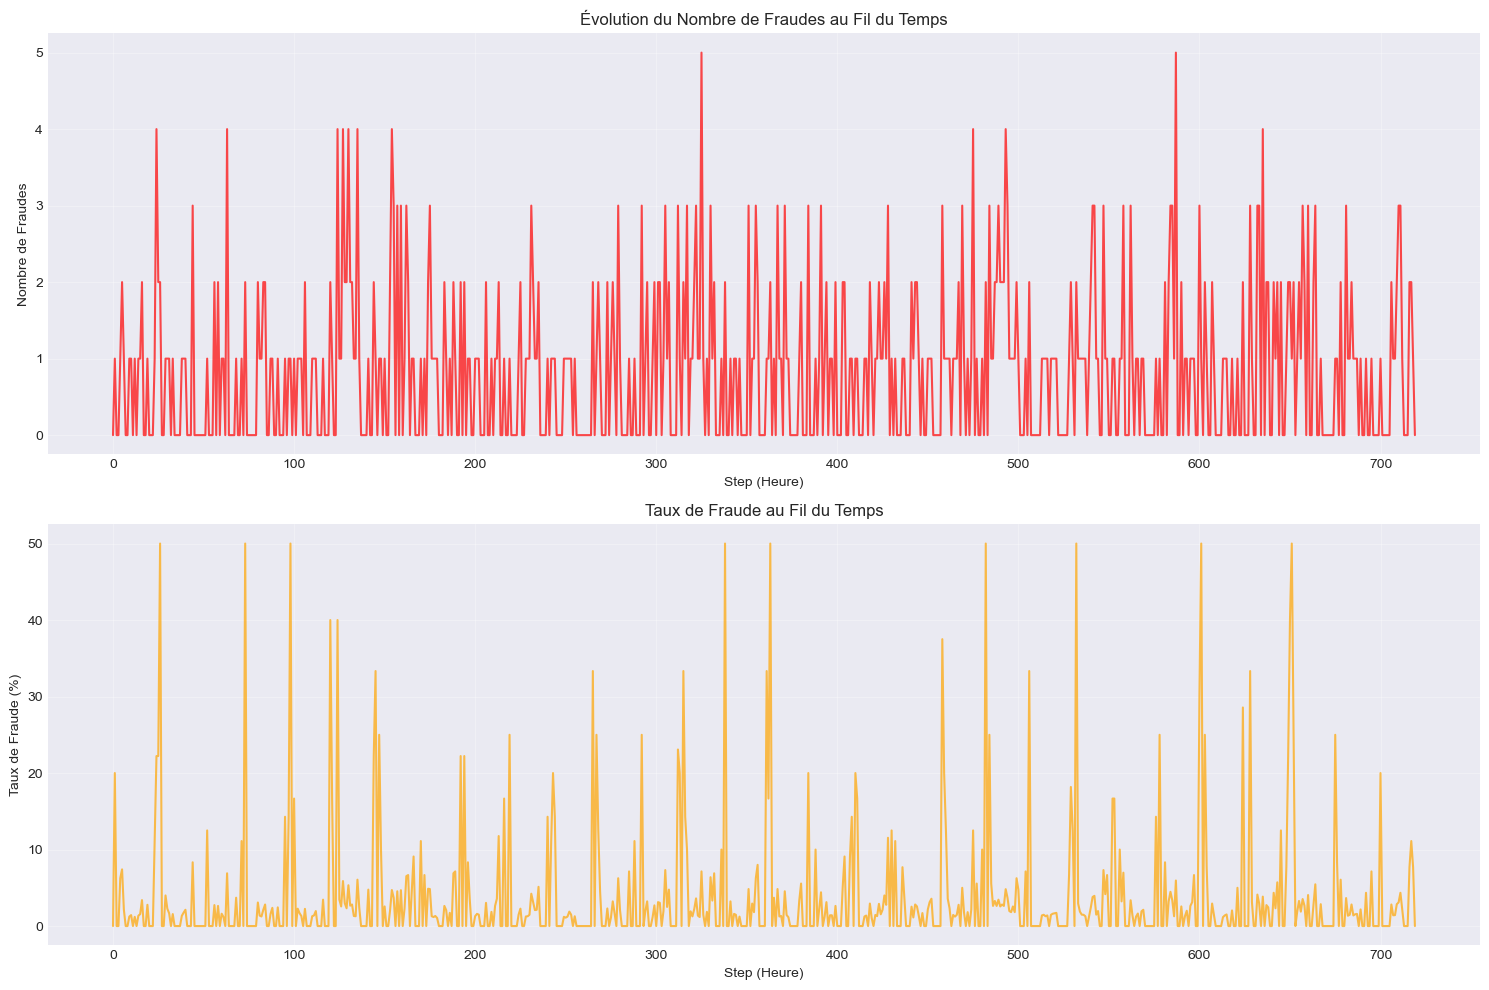

In [24]:
# Analyse temporelle - Step représente les heures (1-744 = 31 jours)
# Step 1 = Lundi 00h00

print("\n⏰ Analyse temporelle:")
print(f"  - Période couverte: {train_df['step'].min()} à {train_df['step'].max()} heures")
print(f"  - Nombre de jours: {train_df['step'].max() / 24:.0f} jours")

# Fraude par période de temps
fraud_by_step = train_df.groupby('step')['is_fraud'].agg(['sum', 'mean', 'count'])

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Évolution du nombre de fraudes
axes[0].plot(fraud_by_step.index, fraud_by_step['sum'], color='red', alpha=0.7)
axes[0].set_xlabel('Step (Heure)')
axes[0].set_ylabel('Nombre de Fraudes')
axes[0].set_title('Évolution du Nombre de Fraudes au Fil du Temps')
axes[0].grid(True, alpha=0.3)

# Taux de fraude
axes[1].plot(fraud_by_step.index, fraud_by_step['mean'] * 100, color='orange', alpha=0.7)
axes[1].set_xlabel('Step (Heure)')
axes[1].set_ylabel('Taux de Fraude (%)')
axes[1].set_title('Taux de Fraude au Fil du Temps')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.5 Analyse de l'Âge


👥 Statistiques d'âge:


,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,29405.0,34.532903,16.057592,18.0,23.0,28.0,43.0,90.0
1,595.0,33.721008,16.534002,18.0,22.0,27.0,40.0,88.0


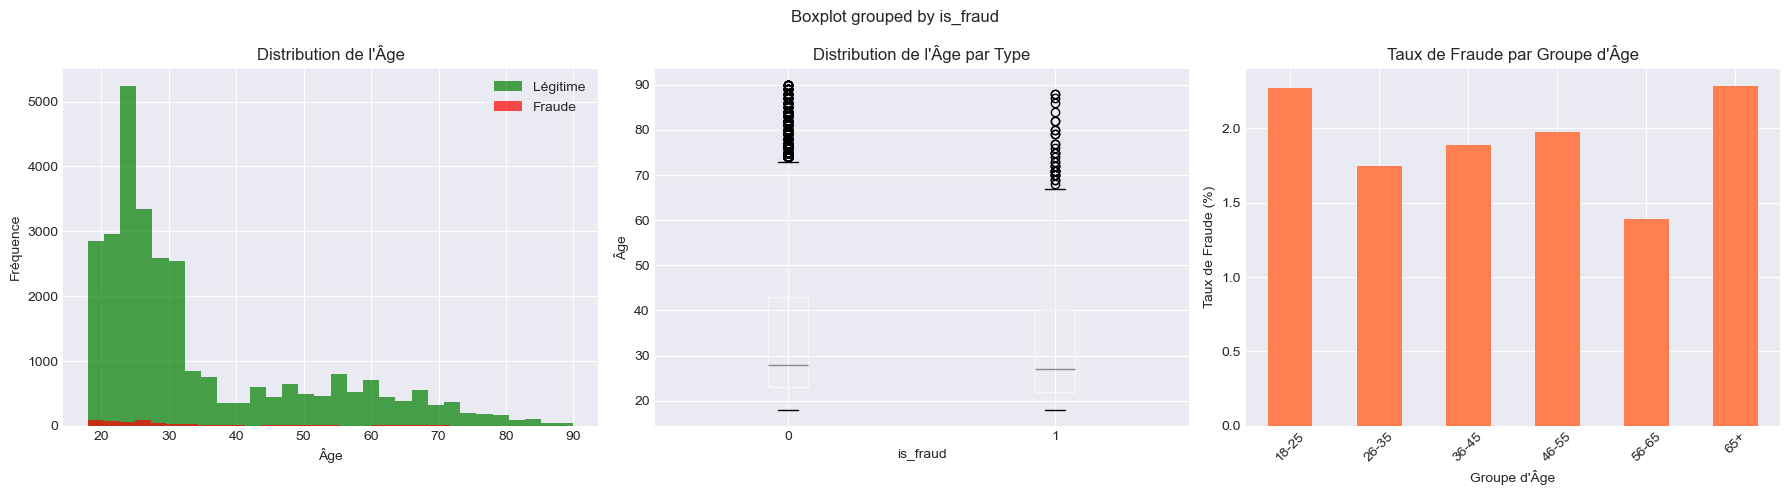

In [27]:
# Analyse de l'âge
print("\n👥 Statistiques d'âge:")
age_stats = train_df.groupby('is_fraud')['age'].describe()
display(age_stats)

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribution de l'âge
axes[0].hist(train_df[train_df['is_fraud']==0]['age'], bins=30, alpha=0.7, label='Légitime', color='green')
axes[0].hist(train_df[train_df['is_fraud']==1]['age'], bins=30, alpha=0.7, label='Fraude', color='red')
axes[0].set_xlabel('Âge')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution de l\'Âge')
axes[0].legend()

# Boxplot
train_df.boxplot(column='age', by='is_fraud', ax=axes[1])
axes[1].set_title('Distribution de l\'Âge par Type')
axes[1].set_xlabel('is_fraud')
axes[1].set_ylabel('Âge')

# Taux de fraude par groupe d'âge
age_bins = [0, 25, 35, 45, 55, 65, 100]
age_labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
train_df['age_group'] = pd.cut(train_df['age'], bins=age_bins, labels=age_labels)
fraud_by_age = train_df.groupby('age_group')['is_fraud'].mean() * 100
fraud_by_age.plot(kind='bar', ax=axes[2], color='coral')
axes[2].set_title('Taux de Fraude par Groupe d\'Âge')
axes[2].set_xlabel('Groupe d\'Âge')
axes[2].set_ylabel('Taux de Fraude (%)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 3.6 Matrice de Corrélation

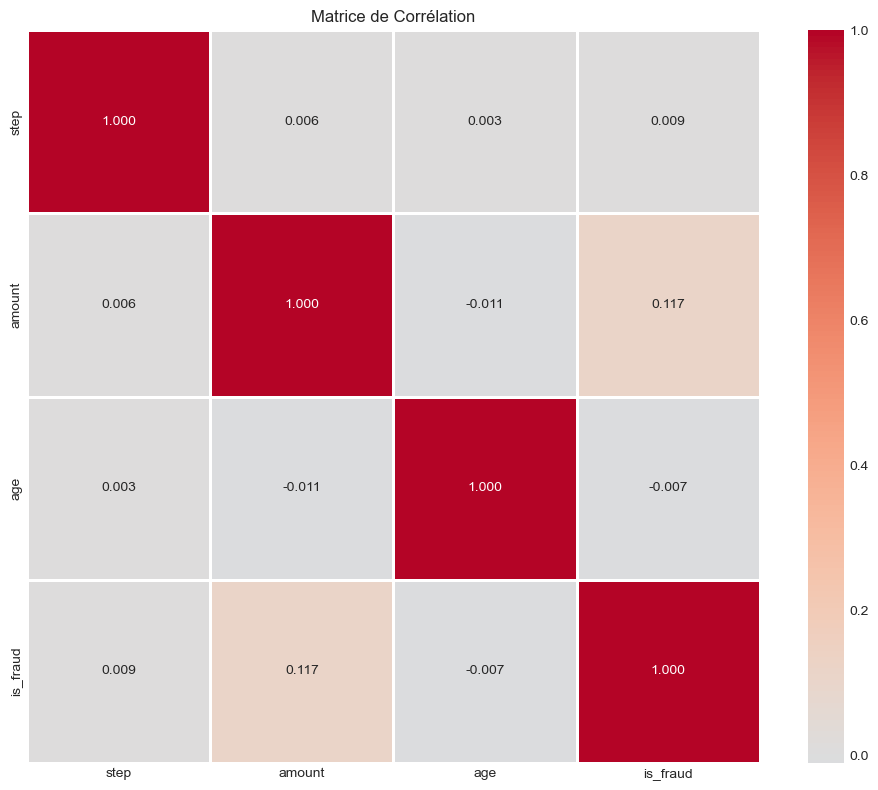


🔗 Corrélation avec is_fraud:
is_fraud    1.000000
amount      0.117376
step        0.008655
age        -0.007045
Name: is_fraud, dtype: float64


In [30]:
# Matrice de corrélation
numeric_cols = ['step', 'amount', 'age', 'is_fraud']
correlation_matrix = train_df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.3f')
plt.title('Matrice de Corrélation')
plt.tight_layout()
plt.show()

print("\n🔗 Corrélation avec is_fraud:")
print(correlation_matrix['is_fraud'].sort_values(ascending=False))

## 🛠️ 4. Feature Engineering et Préparation des Données

### 4.1 Feature Engineering Basique

In [34]:
def create_basic_features(df):
    """
    Crée des features basiques pour le dataset
    """
    df = df.copy()
    
    # 1. Features temporelles (Step 1 = Lundi 00h00)
    df['hour_of_day'] = (df['step'] - 1) % 24  # Heure de la journée (0-23)
    df['day_of_week'] = ((df['step'] - 1) // 24) % 7  # Jour de la semaine (0=Lundi, 6=Dimanche)
    df['day_of_month'] = (df['step'] - 1) // 24 + 1  # Jour du mois (1-31)
    
    # 2. Période de la journée
    df['is_night'] = ((df['hour_of_day'] >= 0) & (df['hour_of_day'] < 6)).astype(int)  # Nuit (0h-6h)
    df['is_morning'] = ((df['hour_of_day'] >= 6) & (df['hour_of_day'] < 12)).astype(int)  # Matin (6h-12h)
    df['is_afternoon'] = ((df['hour_of_day'] >= 12) & (df['hour_of_day'] < 18)).astype(int)  # Après-midi (12h-18h)
    df['is_evening'] = ((df['hour_of_day'] >= 18) & (df['hour_of_day'] < 24)).astype(int)  # Soir (18h-24h)
    
    # 3. Weekend
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)  # Samedi et Dimanche
    
    # 4. Features sur les montants
    df['amount_log'] = np.log1p(df['amount'])  # Log du montant
    df['amount_sqrt'] = np.sqrt(df['amount'])  # Racine carrée du montant
    
    # 5. Catégorisation des montants
    df['amount_category'] = pd.cut(df['amount'], 
                                     bins=[0, 10000, 50000, 100000, 500000, float('inf')],
                                     labels=['très_faible', 'faible', 'moyen', 'élevé', 'très_élevé'])
    
    # 6. Catégorisation de l'âge
    df['age_category'] = pd.cut(df['age'], 
                                 bins=[0, 25, 35, 45, 55, 65, 100],
                                 labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])
    
    return df

# Application du feature engineering
print("🔧 Application du Feature Engineering Basique...")
train_df_fe = create_basic_features(train_df)
test_df_fe = create_basic_features(test_df)

print(f"✅ Features créées! Nouvelles dimensions: {train_df_fe.shape}")
print(f"\n📝 Nouvelles features:")
new_features = set(train_df_fe.columns) - set(train_df.columns)
for feat in sorted(new_features):
    print(f"  - {feat}")

🔧 Application du Feature Engineering Basique...
✅ Features créées! Nouvelles dimensions: (30000, 20)

📝 Nouvelles features:
  - age_category
  - amount_category
  - amount_log
  - amount_sqrt
  - day_of_month
  - day_of_week
  - hour_of_day
  - is_afternoon
  - is_evening
  - is_morning
  - is_night
  - is_weekend


### 4.2 Feature Engineering Avancé

In [37]:
def create_advanced_features(df):
    """
    Crée des features avancées basées sur l'agrégation par client
    """
    df = df.copy()
    
    # 1. Statistiques par client
    customer_stats = df.groupby('customer_id').agg({
        'amount': ['count', 'sum', 'mean', 'std', 'min', 'max'],
        'step': ['min', 'max']
    }).reset_index()
    
    customer_stats.columns = ['customer_id', 
                               'customer_transaction_count',
                               'customer_total_amount',
                               'customer_mean_amount',
                               'customer_std_amount',
                               'customer_min_amount',
                               'customer_max_amount',
                               'customer_first_step',
                               'customer_last_step']
    
    # Calcul de la durée d'activité
    customer_stats['customer_activity_duration'] = (customer_stats['customer_last_step'] - 
                                                      customer_stats['customer_first_step'])
    
    # Fréquence des transactions
    customer_stats['customer_transaction_frequency'] = (customer_stats['customer_transaction_count'] / 
                                                          (customer_stats['customer_activity_duration'] + 1))
    
    # Merge avec le dataset principal
    df = df.merge(customer_stats, on='customer_id', how='left')
    
    # 2. Features relationnelles
    df['amount_vs_customer_mean'] = df['amount'] / (df['customer_mean_amount'] + 1)
    df['amount_vs_customer_max'] = df['amount'] / (df['customer_max_amount'] + 1)
    
    # 3. Features par type de transaction
    type_stats = df.groupby(['customer_id', 'type']).size().reset_index(name='customer_type_count')
    df = df.merge(type_stats, on=['customer_id', 'type'], how='left')
    df['customer_type_count'] = df['customer_type_count'].fillna(0)
    
    # 4. Remplissage des valeurs manquantes pour std
    df['customer_std_amount'] = df['customer_std_amount'].fillna(0)
    
    return df

# Application du feature engineering avancé
print("🚀 Application du Feature Engineering Avancé...")
train_df_advanced = create_advanced_features(train_df_fe)
test_df_advanced = create_advanced_features(test_df_fe)

print(f"✅ Features avancées créées! Dimensions: {train_df_advanced.shape}")

🚀 Application du Feature Engineering Avancé...
✅ Features avancées créées! Dimensions: (30000, 33)


### 4.3 Préparation Finale des Données

In [40]:
from sklearn.preprocessing import LabelEncoder

def prepare_data(train_df, test_df):
    """
    Prépare les données pour la modélisation
    """
    # Colonnes à supprimer
    cols_to_drop = ['transaction_id', 'customer_id', 'age_group', 'amount_category', 'age_category']
    
    # Séparation features et target
    X_train = train_df.drop(cols_to_drop + ['is_fraud'], axis=1, errors='ignore')
    y_train = train_df['is_fraud']

    # Important : errors='ignore' pour éviter les KeyError
    X_test = test_df.drop(cols_to_drop, axis=1, errors='ignore')
    
    # Encodage des variables catégorielles
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
    
    for col in categorical_cols:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str)) if col in X_test.columns else 0
    
    return X_train, y_train, X_test


# Préparation des données
print("📊 Préparation finale des données...")
X_train, y_train, X_test = prepare_data(train_df_advanced, test_df_advanced)

print(f"\n✅ Données préparées:")
print(f"  - X_train: {X_train.shape}")
print(f"  - y_train: {y_train.shape}")
print(f"  - X_test: {X_test.shape}")

📊 Préparation finale des données...

✅ Données préparées:
  - X_train: (30000, 27)
  - y_train: (30000,)
  - X_test: (10000, 27)


### 4.4 Split Train/Validation

In [43]:
# Split stratifié pour conserver la proportion de fraudes
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("✂️ Split Train/Validation effectué:")
print(f"  - Train: {X_train_split.shape[0]} transactions")
print(f"  - Validation: {X_val_split.shape[0]} transactions")
print(f"\n📊 Distribution de la fraude:")
print(f"  - Train: {y_train_split.mean()*100:.2f}% fraudes")
print(f"  - Validation: {y_val_split.mean()*100:.2f}% fraudes")

✂️ Split Train/Validation effectué:
  - Train: 24000 transactions
  - Validation: 6000 transactions

📊 Distribution de la fraude:
  - Train: 1.98% fraudes
  - Validation: 1.98% fraudes


### 4.5 Normalisation des Données

In [46]:
# Normalisation avec StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val_split)
X_test_scaled = scaler.transform(X_test)

print("✅ Normalisation effectuée avec StandardScaler")

✅ Normalisation effectuée avec StandardScaler


## 📈 5. Baseline: Régression Logistique

### 5.1 Entraînement du Modèle Baseline

In [50]:
# Fonction d'évaluation
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name="Model"):
    """
    Évalue un modèle et affiche les métriques
    """
    # Prédictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Prédictions de probabilités
    if hasattr(model, 'predict_proba'):
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_val_proba = model.predict_proba(X_val)[:, 1]
    else:
        y_train_proba = y_train_pred
        y_val_proba = y_val_pred
    
    # Calcul des métriques
    results = {
        'Model': model_name,
        'Train F1': f1_score(y_train, y_train_pred),
        'Val F1': f1_score(y_val, y_val_pred),
        'Train Precision': precision_score(y_train, y_train_pred),
        'Val Precision': precision_score(y_val, y_val_pred),
        'Train Recall': recall_score(y_train, y_train_pred),
        'Val Recall': recall_score(y_val, y_val_pred),
        'Train AUC': roc_auc_score(y_train, y_train_proba),
        'Val AUC': roc_auc_score(y_val, y_val_proba)
    }
    
    # Affichage
    print(f"\n{'='*60}")
    print(f"📊 Résultats: {model_name}")
    print(f"{'='*60}")
    print(f"\n🎯 F1-Score:")
    print(f"  - Train: {results['Train F1']:.4f}")
    print(f"  - Validation: {results['Val F1']:.4f}")
    print(f"\n🎯 Precision:")
    print(f"  - Train: {results['Train Precision']:.4f}")
    print(f"  - Validation: {results['Val Precision']:.4f}")
    print(f"\n🎯 Recall:")
    print(f"  - Train: {results['Train Recall']:.4f}")
    print(f"  - Validation: {results['Val Recall']:.4f}")
    print(f"\n🎯 AUC-ROC:")
    print(f"  - Train: {results['Train AUC']:.4f}")
    print(f"  - Validation: {results['Val AUC']:.4f}")
    
    # Matrice de confusion
    print(f"\n📊 Matrice de Confusion (Validation):")
    cm = confusion_matrix(y_val, y_val_pred)
    print(cm)
    print(f"\n  - Vrais Négatifs (TN): {cm[0,0]:,}")
    print(f"  - Faux Positifs (FP): {cm[0,1]:,}")
    print(f"  - Faux Négatifs (FN): {cm[1,0]:,}")
    print(f"  - Vrais Positifs (TP): {cm[1,1]:,}")
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Matrice de confusion
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Matrice de Confusion - {model_name}')
    axes[0].set_xlabel('Prédiction')
    axes[0].set_ylabel('Réalité')
    axes[0].set_xticklabels(['Légitime', 'Fraude'])
    axes[0].set_yticklabels(['Légitime', 'Fraude'])
    
    # Courbe ROC
    fpr, tpr, _ = roc_curve(y_val, y_val_proba)
    axes[1].plot(fpr, tpr, label=f'AUC = {results["Val AUC"]:.4f}')
    axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[1].set_xlabel('Taux de Faux Positifs')
    axes[1].set_ylabel('Taux de Vrais Positifs')
    axes[1].set_title(f'Courbe ROC - {model_name}')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results

🚀 Entraînement de la Régression Logistique (Baseline)...

📊 Résultats: Régression Logistique (Baseline)

🎯 F1-Score:
  - Train: 0.1574
  - Validation: 0.1581

🎯 Precision:
  - Train: 0.0861
  - Validation: 0.0865

🎯 Recall:
  - Train: 0.9139
  - Validation: 0.9160

🎯 AUC-ROC:
  - Train: 0.9048
  - Validation: 0.9071

📊 Matrice de Confusion (Validation):
[[4730 1151]
 [  10  109]]

  - Vrais Négatifs (TN): 4,730
  - Faux Positifs (FP): 1,151
  - Faux Négatifs (FN): 10
  - Vrais Positifs (TP): 109


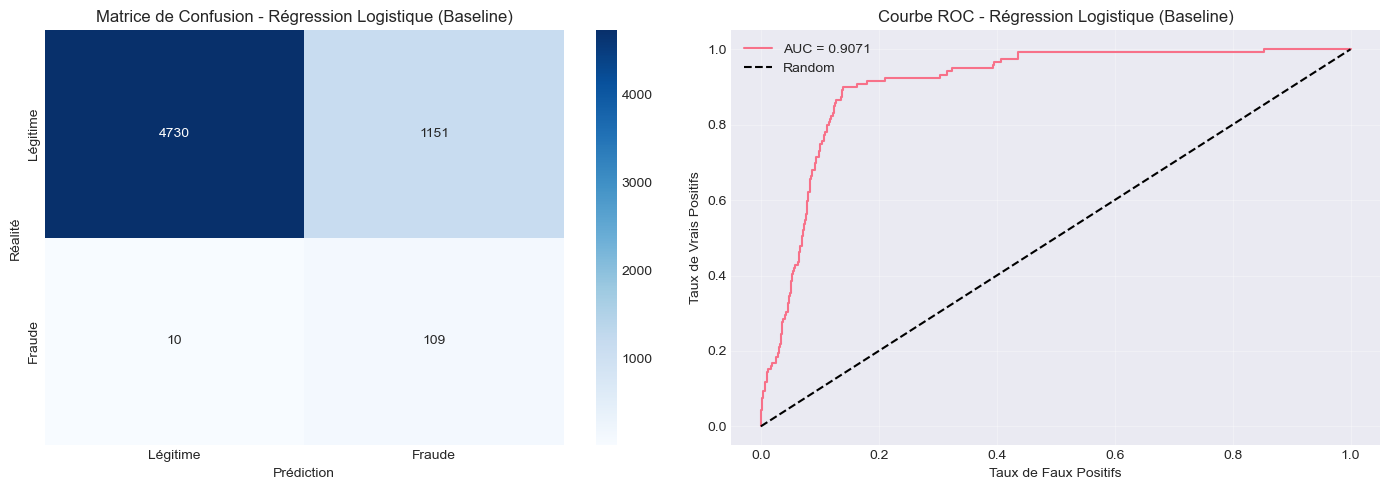

In [52]:
# Entraînement de la Régression Logistique (Baseline)
print("🚀 Entraînement de la Régression Logistique (Baseline)...")

baseline_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # Important pour gérer le déséquilibre
    random_state=42
)

baseline_model.fit(X_train_scaled, y_train_split)

# Évaluation
baseline_results = evaluate_model(
    baseline_model, 
    X_train_scaled, y_train_split,
    X_val_scaled, y_val_split,
    "Régression Logistique (Baseline)"
)

### 5.2 Analyse des Features Importantes (Baseline)


📊 Top 15 Features les plus importantes (Baseline):


,feature,coefficient
1,type,1.881864
23,customer_transaction_frequency,1.647750
12,amount_log,1.502375
11,is_weekend,0.330096
7,is_night,0.123992
10,is_evening,0.110630
13,amount_sqrt,0.018421
18,customer_min_amount,0.015843
2,amount,0.015644
16,customer_mean_amount,0.012249


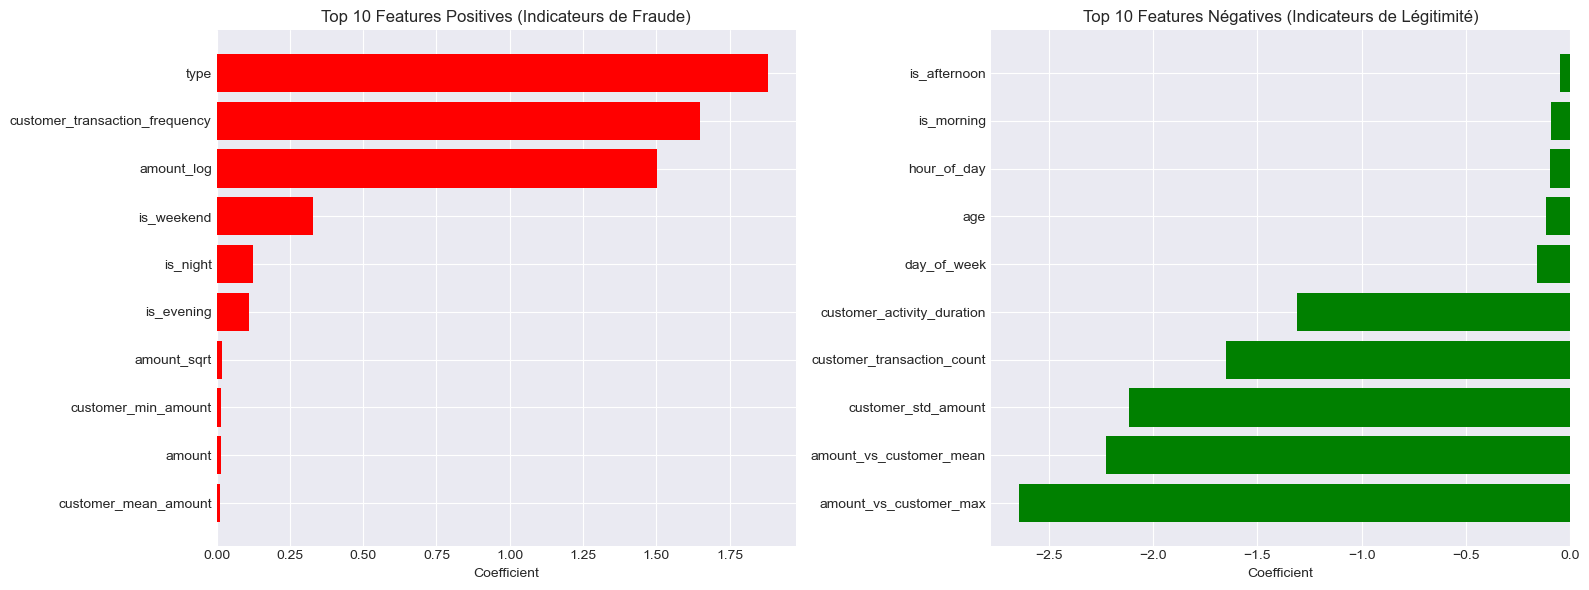

In [55]:
# Feature importance pour la régression logistique
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': baseline_model.coef_[0]
}).sort_values('coefficient', ascending=False)

print("\n📊 Top 15 Features les plus importantes (Baseline):")
display(feature_importance.head(15))

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top positifs
top_positive = feature_importance.head(10)
axes[0].barh(top_positive['feature'], top_positive['coefficient'], color='red')
axes[0].set_xlabel('Coefficient')
axes[0].set_title('Top 10 Features Positives (Indicateurs de Fraude)')
axes[0].invert_yaxis()

# Top négatifs
top_negative = feature_importance.tail(10)
axes[1].barh(top_negative['feature'], top_negative['coefficient'], color='green')
axes[1].set_xlabel('Coefficient')
axes[1].set_title('Top 10 Features Négatives (Indicateurs de Légitimité)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 🚀 6. Modèles Avancés

### 6.1 Gestion du Déséquilibre avec SMOTE

In [59]:
# Application de SMOTE pour équilibrer les classes
print("⚖️ Application de SMOTE pour équilibrer les classes...")

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train_split)

print(f"\n✅ Résultat du rééchantillonnage:")
print(f"  - Avant SMOTE: {X_train_scaled.shape[0]} transactions")
print(f"  - Après SMOTE: {X_train_balanced.shape[0]} transactions")
print(f"\n📊 Distribution après SMOTE:")
print(f"  - Légitime: {(y_train_balanced == 0).sum():,} ({(y_train_balanced == 0).mean()*100:.1f}%)")
print(f"  - Fraude: {(y_train_balanced == 1).sum():,} ({(y_train_balanced == 1).mean()*100:.1f}%)")

⚖️ Application de SMOTE pour équilibrer les classes...

✅ Résultat du rééchantillonnage:
  - Avant SMOTE: 24000 transactions
  - Après SMOTE: 47048 transactions

📊 Distribution après SMOTE:
  - Légitime: 23,524 (50.0%)
  - Fraude: 23,524 (50.0%)


### 6.2 Random Forest

🌲 Entraînement du Random Forest...

📊 Résultats: Random Forest

🎯 F1-Score:
  - Train: 0.4925
  - Validation: 0.4240

🎯 Precision:
  - Train: 0.3343
  - Validation: 0.2845

🎯 Recall:
  - Train: 0.9349
  - Validation: 0.8319

🎯 AUC-ROC:
  - Train: 0.9935
  - Validation: 0.9492

📊 Matrice de Confusion (Validation):
[[5632  249]
 [  20   99]]

  - Vrais Négatifs (TN): 5,632
  - Faux Positifs (FP): 249
  - Faux Négatifs (FN): 20
  - Vrais Positifs (TP): 99


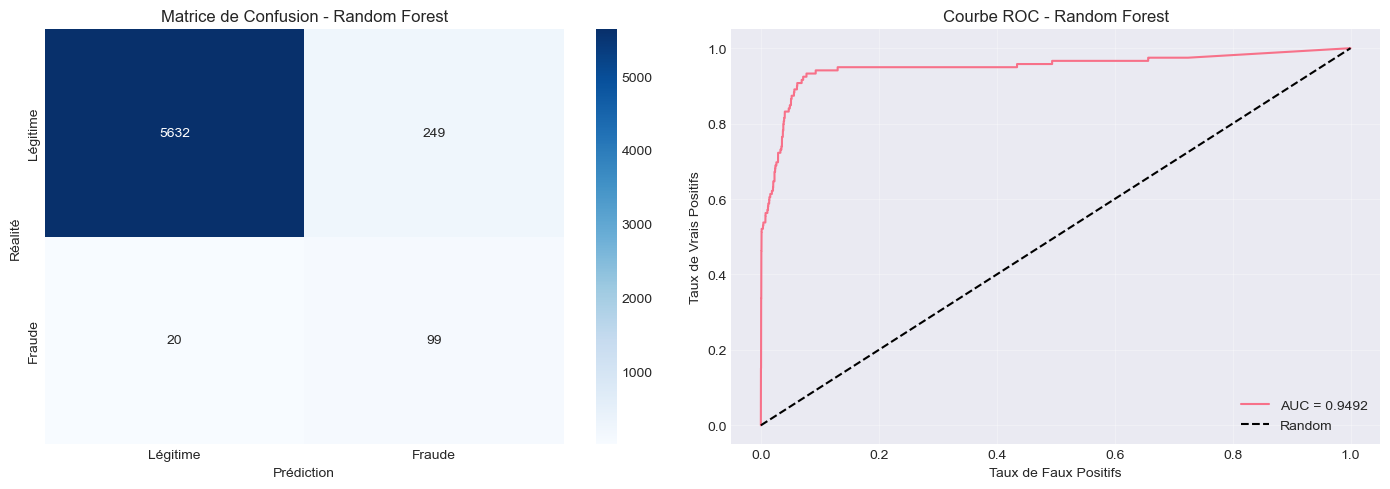

In [62]:
# Entraînement Random Forest
print("🌲 Entraînement du Random Forest...")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_balanced, y_train_balanced)

# Évaluation
rf_results = evaluate_model(
    rf_model,
    X_train_scaled, y_train_split,
    X_val_scaled, y_val_split,
    "Random Forest"
)


📊 Top 15 Features les plus importantes (Random Forest):


,feature,importance
1,type,0.303148
18,customer_min_amount,0.083646
16,customer_mean_amount,0.082113
2,amount,0.072383
19,customer_max_amount,0.068948
15,customer_total_amount,0.059211
13,amount_sqrt,0.049142
4,hour_of_day,0.048455
12,amount_log,0.038548
24,amount_vs_customer_mean,0.038510


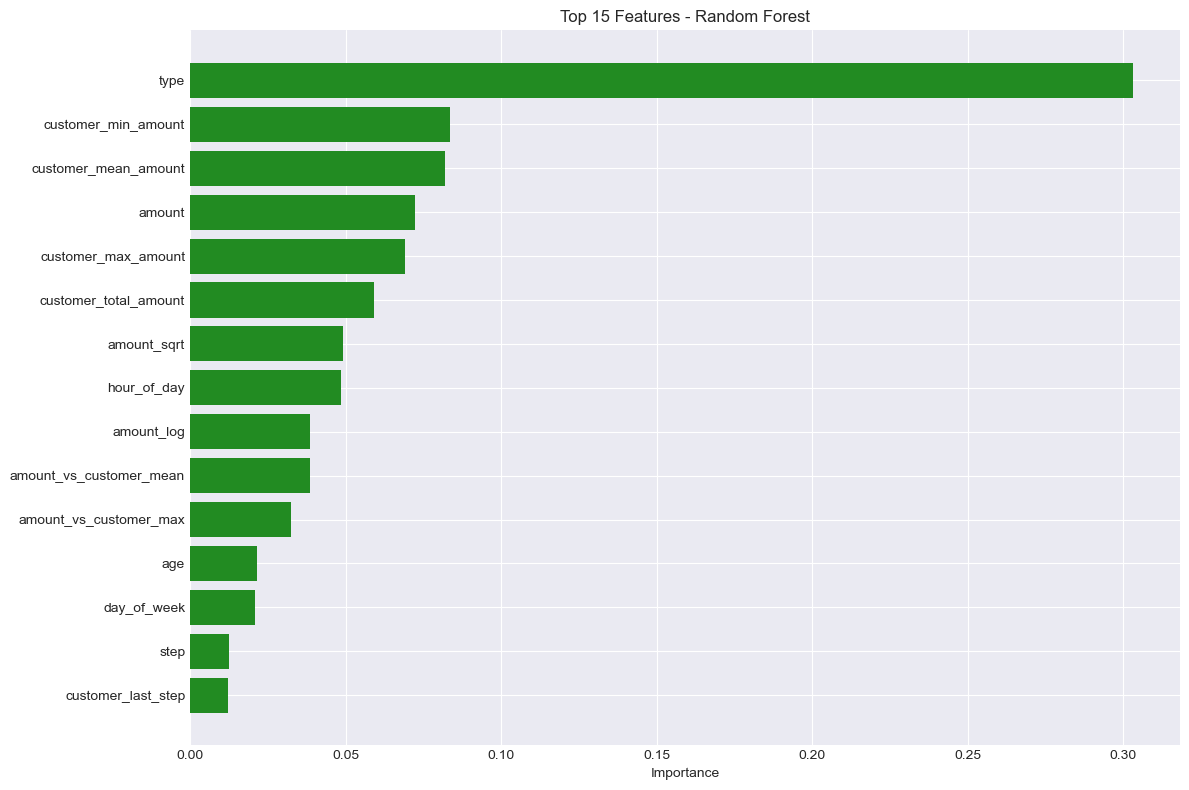

In [64]:
# Feature Importance (Random Forest)
rf_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Top 15 Features les plus importantes (Random Forest):")
display(rf_feature_importance.head(15))

# Visualisation
plt.figure(figsize=(12, 8))
plt.barh(rf_feature_importance.head(15)['feature'], 
         rf_feature_importance.head(15)['importance'],
         color='forestgreen')
plt.xlabel('Importance')
plt.title('Top 15 Features - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 6.3 XGBoost

⚡ Entraînement de XGBoost...

📊 Résultats: XGBoost

🎯 F1-Score:
  - Train: 0.8508
  - Validation: 0.7420

🎯 Precision:
  - Train: 0.7403
  - Validation: 0.6402

🎯 Recall:
  - Train: 1.0000
  - Validation: 0.8824

🎯 AUC-ROC:
  - Train: 0.9996
  - Validation: 0.9687

📊 Matrice de Confusion (Validation):
[[5822   59]
 [  14  105]]

  - Vrais Négatifs (TN): 5,822
  - Faux Positifs (FP): 59
  - Faux Négatifs (FN): 14
  - Vrais Positifs (TP): 105


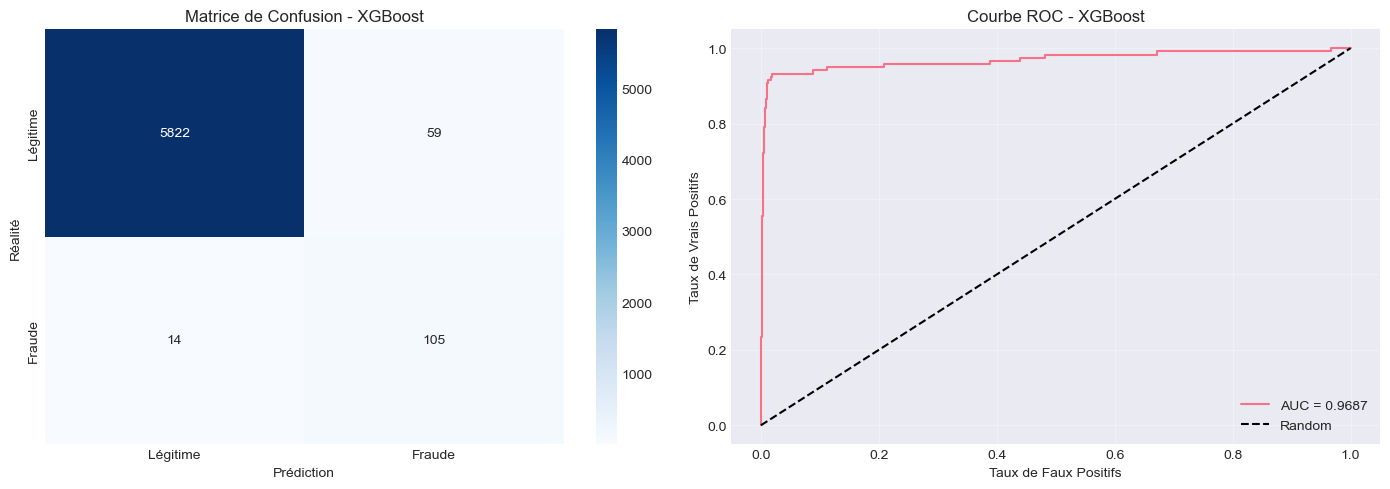

In [67]:
# Entraînement XGBoost
print("⚡ Entraînement de XGBoost...")

# Calcul du scale_pos_weight pour gérer le déséquilibre
scale_pos_weight = (y_train_split == 0).sum() / (y_train_split == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    min_child_weight=5,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_model.fit(
    X_train_scaled, y_train_split,
    eval_set=[(X_val_scaled, y_val_split)],
    verbose=False
)

# Évaluation
xgb_results = evaluate_model(
    xgb_model,
    X_train_scaled, y_train_split,
    X_val_scaled, y_val_split,
    "XGBoost"
)


📊 Top 15 Features les plus importantes (XGBoost):


,feature,importance
1,type,0.266043
25,amount_vs_customer_max,0.203081
16,customer_mean_amount,0.173285
24,amount_vs_customer_mean,0.050674
15,customer_total_amount,0.038912
18,customer_min_amount,0.032626
2,amount,0.031921
9,is_afternoon,0.027086
4,hour_of_day,0.024579
8,is_morning,0.023415


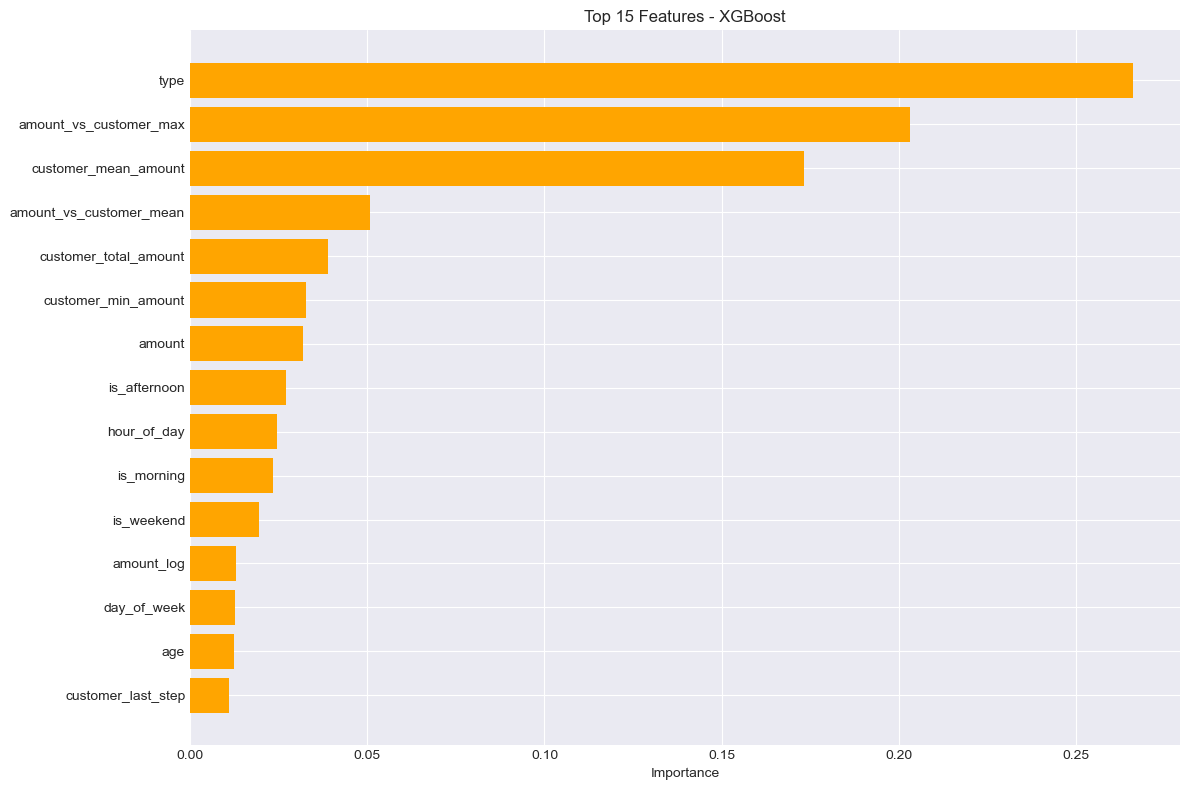

In [69]:
# Feature Importance (XGBoost)
xgb_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Top 15 Features les plus importantes (XGBoost):")
display(xgb_feature_importance.head(15))

# Visualisation
plt.figure(figsize=(12, 8))
plt.barh(xgb_feature_importance.head(15)['feature'], 
         xgb_feature_importance.head(15)['importance'],
         color='orange')
plt.xlabel('Importance')
plt.title('Top 15 Features - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 6.4 Gradient Boosting

📈 Entraînement du Gradient Boosting...

📊 Résultats: Gradient Boosting

🎯 F1-Score:
  - Train: 0.5000
  - Validation: 0.4362

🎯 Precision:
  - Train: 0.3505
  - Validation: 0.3013

🎯 Recall:
  - Train: 0.8718
  - Validation: 0.7899

🎯 AUC-ROC:
  - Train: 0.9813
  - Validation: 0.9617

📊 Matrice de Confusion (Validation):
[[5663  218]
 [  25   94]]

  - Vrais Négatifs (TN): 5,663
  - Faux Positifs (FP): 218
  - Faux Négatifs (FN): 25
  - Vrais Positifs (TP): 94


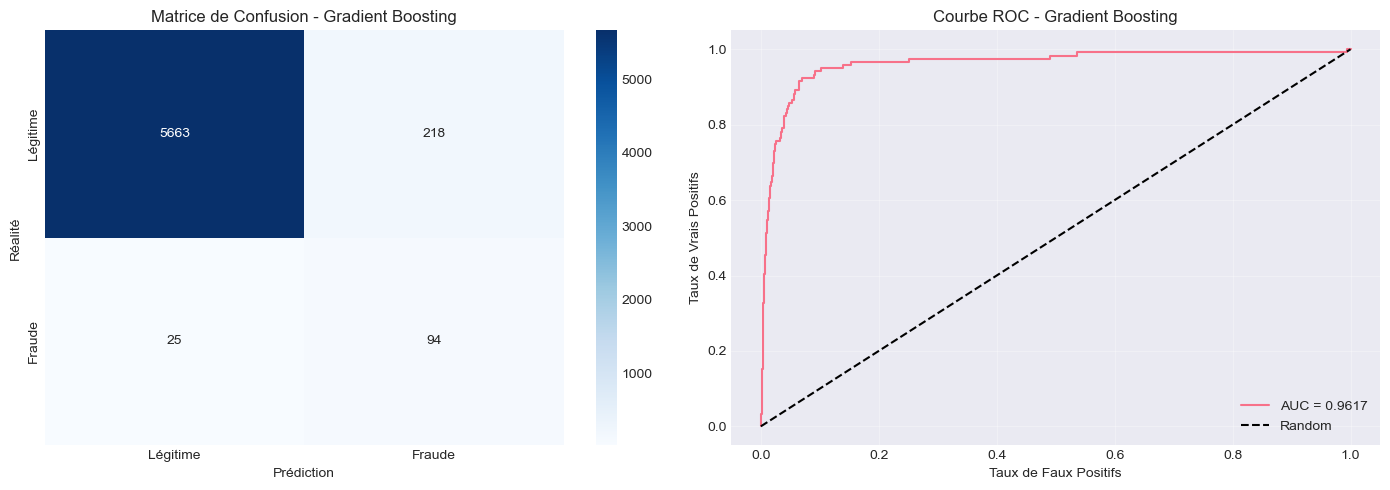

In [72]:
# Entraînement Gradient Boosting
print("📈 Entraînement du Gradient Boosting...")

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,
    random_state=42
)

gb_model.fit(X_train_balanced, y_train_balanced)

# Évaluation
gb_results = evaluate_model(
    gb_model,
    X_train_scaled, y_train_split,
    X_val_scaled, y_val_split,
    "Gradient Boosting"
)

## 📊 7. Comparaison des Modèles


📊 COMPARAISON DES MODÈLES


,Model,Val F1,Val Precision,Val Recall,Val AUC
0,Régression Logistique (Baseline),0.158086,0.086508,0.915966,0.907127
1,Random Forest,0.423983,0.284483,0.831933,0.949228
2,XGBoost,0.742049,0.640244,0.882353,0.968706
3,Gradient Boosting,0.436195,0.301282,0.789916,0.961681


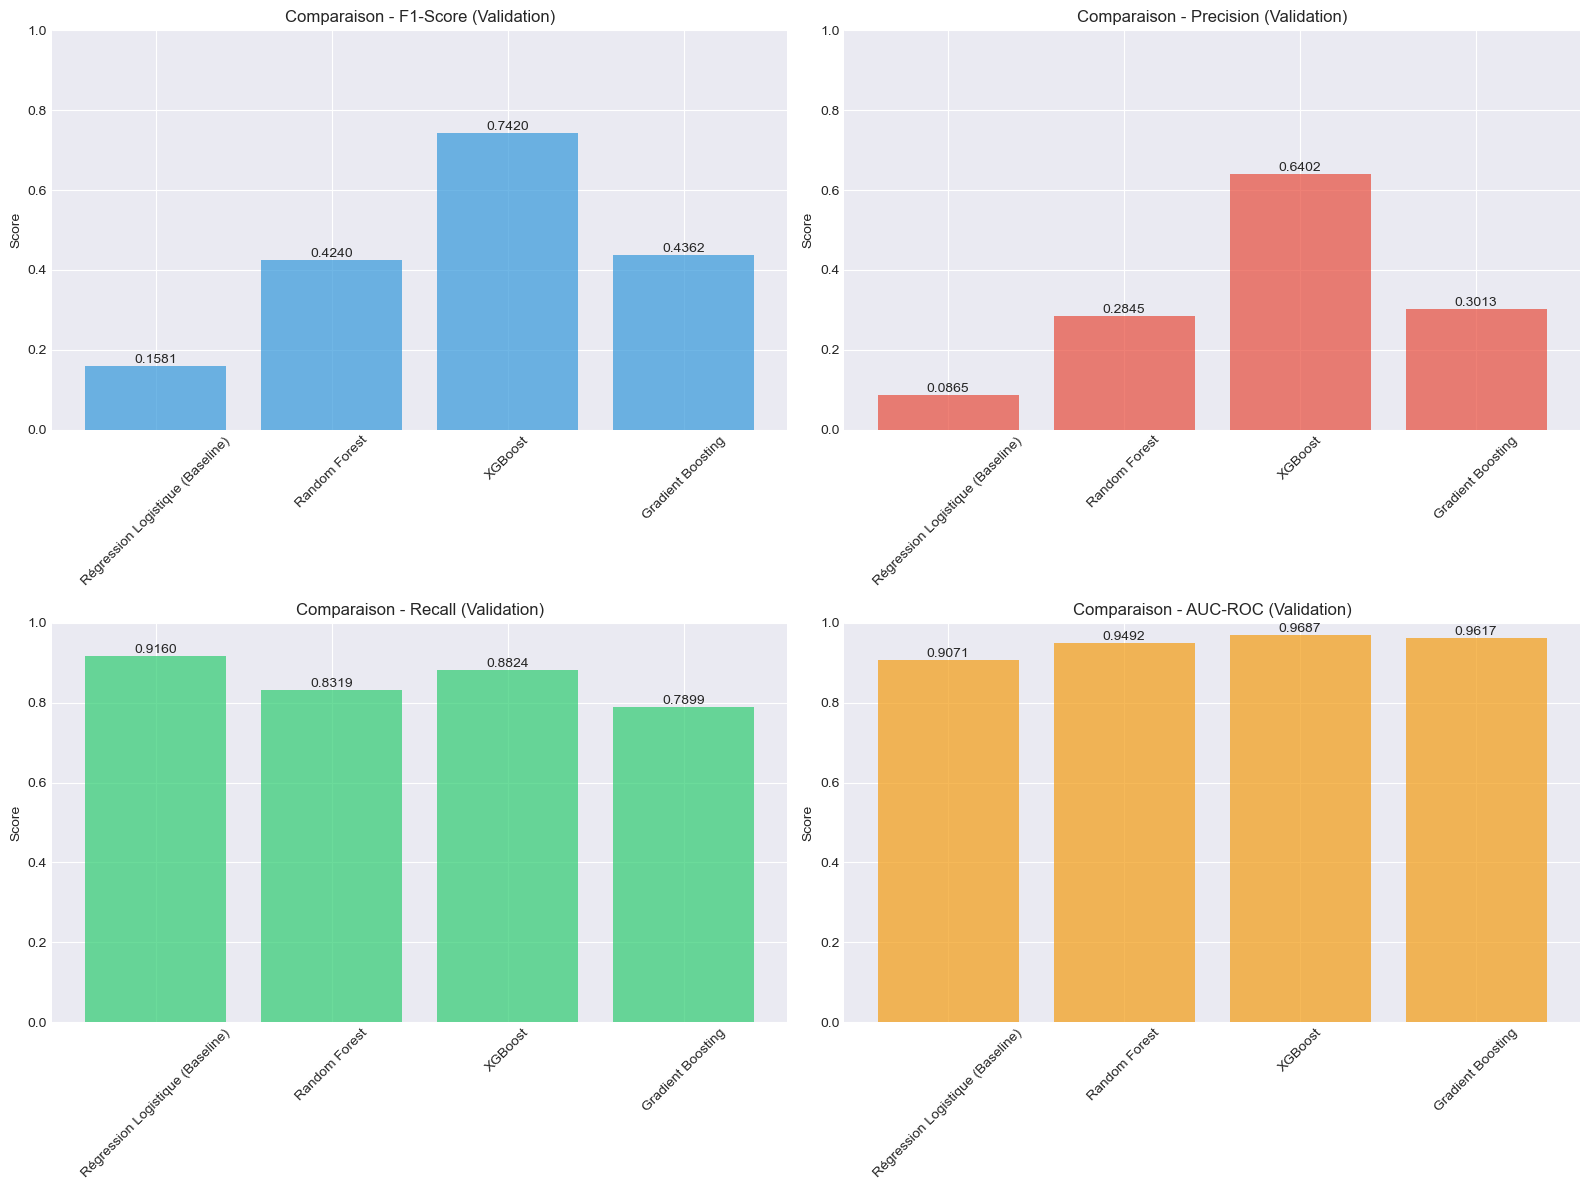


🏆 MEILLEUR MODÈLE: XGBoost
   F1-Score (Validation): 0.7420


In [75]:
# Compilation des résultats
all_results = pd.DataFrame([
    baseline_results,
    rf_results,
    xgb_results,
    gb_results
])

print("\n📊 COMPARAISON DES MODÈLES")
print("="*80)
display(all_results[['Model', 'Val F1', 'Val Precision', 'Val Recall', 'Val AUC']])

# Visualisation comparative
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Val F1', 'Val Precision', 'Val Recall', 'Val AUC']
titles = ['F1-Score', 'Precision', 'Recall', 'AUC-ROC']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    ax = axes[idx // 2, idx % 2]
    values = all_results[metric].values
    bars = ax.bar(all_results['Model'], values, color=color, alpha=0.7)
    ax.set_ylabel('Score')
    ax.set_title(f'Comparaison - {title} (Validation)')
    ax.set_ylim([0, 1])
    ax.tick_params(axis='x', rotation=45)
    
    # Ajouter les valeurs sur les barres
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Identification du meilleur modèle
best_model_idx = all_results['Val F1'].idxmax()
best_model_name = all_results.loc[best_model_idx, 'Model']
best_f1 = all_results.loc[best_model_idx, 'Val F1']

print(f"\n🏆 MEILLEUR MODÈLE: {best_model_name}")
print(f"   F1-Score (Validation): {best_f1:.4f}")

## 🎯 8. Sélection et Optimisation du Modèle Final

In [78]:
# Sélection du meilleur modèle (généralement XGBoost ou Random Forest)
# Ici, nous utilisons XGBoost comme modèle final
print("🎯 Sélection du modèle final: XGBoost")
print("\n🔧 Réentraînement sur l'ensemble des données de train...")

# Réentraînement sur toutes les données de train
X_train_full_scaled = scaler.fit_transform(X_train)

final_model = XGBClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    min_child_weight=5,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

final_model.fit(X_train_full_scaled, y_train)

print("✅ Modèle final entraîné!")

🎯 Sélection du modèle final: XGBoost

🔧 Réentraînement sur l'ensemble des données de train...
✅ Modèle final entraîné!


## 📤 9. Génération de la Soumission

In [81]:
# Prédictions sur le test set
print("🔮 Génération des prédictions sur le test set...")

# Normalisation du test set avec le même scaler
X_test_final_scaled = scaler.transform(X_test)

# Prédictions
test_predictions = final_model.predict(X_test_final_scaled)
test_predictions_proba = final_model.predict_proba(X_test_final_scaled)[:, 1]

# Création du fichier de soumission
submission = pd.DataFrame({
    'transaction_id': test_df['transaction_id'],
    'is_fraud': test_predictions
})

# Sauvegarde
submission.to_csv('submission.csv', index=False)

print(f"\n✅ Fichier submission.csv créé!")
print(f"\n📊 Statistiques des prédictions:")
print(f"  - Total de transactions: {len(submission):,}")
print(f"  - Transactions légitimes: {(test_predictions == 0).sum():,} ({(test_predictions == 0).mean()*100:.2f}%)")
print(f"  - Transactions frauduleuses: {(test_predictions == 1).sum():,} ({(test_predictions == 1).mean()*100:.2f}%)")
print(f"\n🔍 Aperçu de la soumission:")
display(submission.head(10))
display(submission.tail(10))

🔮 Génération des prédictions sur le test set...

✅ Fichier submission.csv créé!

📊 Statistiques des prédictions:
  - Total de transactions: 10,000
  - Transactions légitimes: 9,707 (97.07%)
  - Transactions frauduleuses: 293 (2.93%)

🔍 Aperçu de la soumission:


,transaction_id,is_fraud
0,f9d47afa-6e9f-45a1-a443-afb5132e9986,0
1,a3159433-df38-44d2-b6e1-3920b6f2a42f,0
2,27b30f3c-7688-489f-9c77-d70981bf1a05,1
3,c3566535-87b7-40d5-ac21-7874a193af11,0
4,26ec3542-7f49-4252-b906-78157c647db8,0
5,263251d5-df93-4ee0-8beb-f392a062e777,1
6,9c9eb6d7-ad99-48aa-b87b-8256b00bbfe2,0
7,86a9f7cf-65fe-4d87-9f51-4bab9fdbabf7,0
8,5d69da88-fff8-48a4-8bc4-74353aa077e0,0
9,5455bbc4-2c84-4ee6-9678-5c142d790f54,0


,transaction_id,is_fraud
9990,83434a76-38d5-49f6-a287-6ef21d82e625,0
9991,b3d281d5-85b1-47fb-ad5b-3baa497d3d23,0
9992,2f7fa90e-a148-4c17-b7ef-8fdf0c933da4,0
9993,13bfd06e-49e3-43ed-a359-5154a646b25f,0
9994,4f5f6b08-6260-44f2-8010-53a34885300e,0
9995,c3ea6d9d-deca-4dc7-9dc4-039c3bd5709a,0
9996,04116f54-da40-4cb9-8880-3ea44842d420,0
9997,4c9905fe-2e4c-42f0-8759-f518a145df51,0
9998,36df96d1-df7e-40f1-bf42-9c356e6d8004,0
9999,374c732d-3593-49a0-99d9-9d6215f6b5fe,0


## 📊 10. Analyse des Fraudes Détectées

In [84]:
# Analyse des transactions identifiées comme frauduleuses
test_df_with_predictions = test_df_advanced.copy()
test_df_with_predictions['is_fraud_predicted'] = test_predictions
test_df_with_predictions['fraud_probability'] = test_predictions_proba

# Filtrer les fraudes détectées
detected_frauds = test_df_with_predictions[test_df_with_predictions['is_fraud_predicted'] == 1]

print("\n🚨 ANALYSE DES FRAUDES DÉTECTÉES")
print("="*80)
print(f"\nNombre total de fraudes détectées: {len(detected_frauds):,}")

# Analyse par type de transaction
print("\n💳 Répartition par type de transaction:")
fraud_by_type = detected_frauds['type'].value_counts()
for trans_type, count in fraud_by_type.items():
    percent = (count / len(detected_frauds)) * 100
    print(f"  - {trans_type}: {count:,} ({percent:.1f}%)")

# Statistiques des montants frauduleux
print("\n💰 Statistiques des montants frauduleux (MGA):")
print(f"  - Montant total: {detected_frauds['amount'].sum():,.0f} MGA")
print(f"  - Montant moyen: {detected_frauds['amount'].mean():,.0f} MGA")
print(f"  - Montant médian: {detected_frauds['amount'].median():,.0f} MGA")
print(f"  - Montant minimum: {detected_frauds['amount'].min():,.0f} MGA")
print(f"  - Montant maximum: {detected_frauds['amount'].max():,.0f} MGA")

# Top 10 des fraudes avec la plus haute probabilité
print("\n🎯 Top 10 des fraudes avec la plus haute probabilité:")
top_frauds = detected_frauds.nlargest(10, 'fraud_probability')[[
    'transaction_id', 'type', 'amount', 'age', 'hour_of_day', 'fraud_probability'
]]
display(top_frauds)


🚨 ANALYSE DES FRAUDES DÉTECTÉES

Nombre total de fraudes détectées: 293

💳 Répartition par type de transaction:
  - TRANSFER: 258 (88.1%)
  - PAYMENT: 19 (6.5%)
  - CASH_OUT: 13 (4.4%)
  - DEBIT: 3 (1.0%)

💰 Statistiques des montants frauduleux (MGA):
  - Montant total: 179,338,500 MGA
  - Montant moyen: 612,077 MGA
  - Montant médian: 155,000 MGA
  - Montant minimum: 1,500 MGA
  - Montant maximum: 9,446,900 MGA

🎯 Top 10 des fraudes avec la plus haute probabilité:


,transaction_id,type,amount,age,hour_of_day,fraud_probability
1033,e33ad35d-0b15-4275-95fd-e526c87607d4,TRANSFER,155000,63,18,0.999457
4523,12a89bbb-e487-49e5-a2d7-1518e3b7554b,TRANSFER,155000,32,14,0.999229
500,02d7cf1b-7908-4086-9d19-4aad8c97d15f,TRANSFER,255000,62,19,0.998775
3353,21107988-a909-4a79-b16a-4efbba9202c2,TRANSFER,110000,53,23,0.998737
1713,4eddc580-b778-4b0b-8d1e-720d5739366c,TRANSFER,256000,38,0,0.998691
1938,d82f6cf5-4849-4a3a-a98e-c716f2557158,TRANSFER,155000,42,20,0.998546
4768,39b503df-115d-4df4-bc26-5fd3b2f5100b,TRANSFER,255000,52,8,0.998510
6338,65d8a637-690f-482a-b54d-6ed4485422be,TRANSFER,255000,26,12,0.998486
7836,15f5537a-55da-43f1-bf19-6a8502656146,TRANSFER,155000,54,14,0.998408
149,2ad31625-d8a2-4921-adb9-3ed8da39212f,TRANSFER,155000,64,7,0.998360


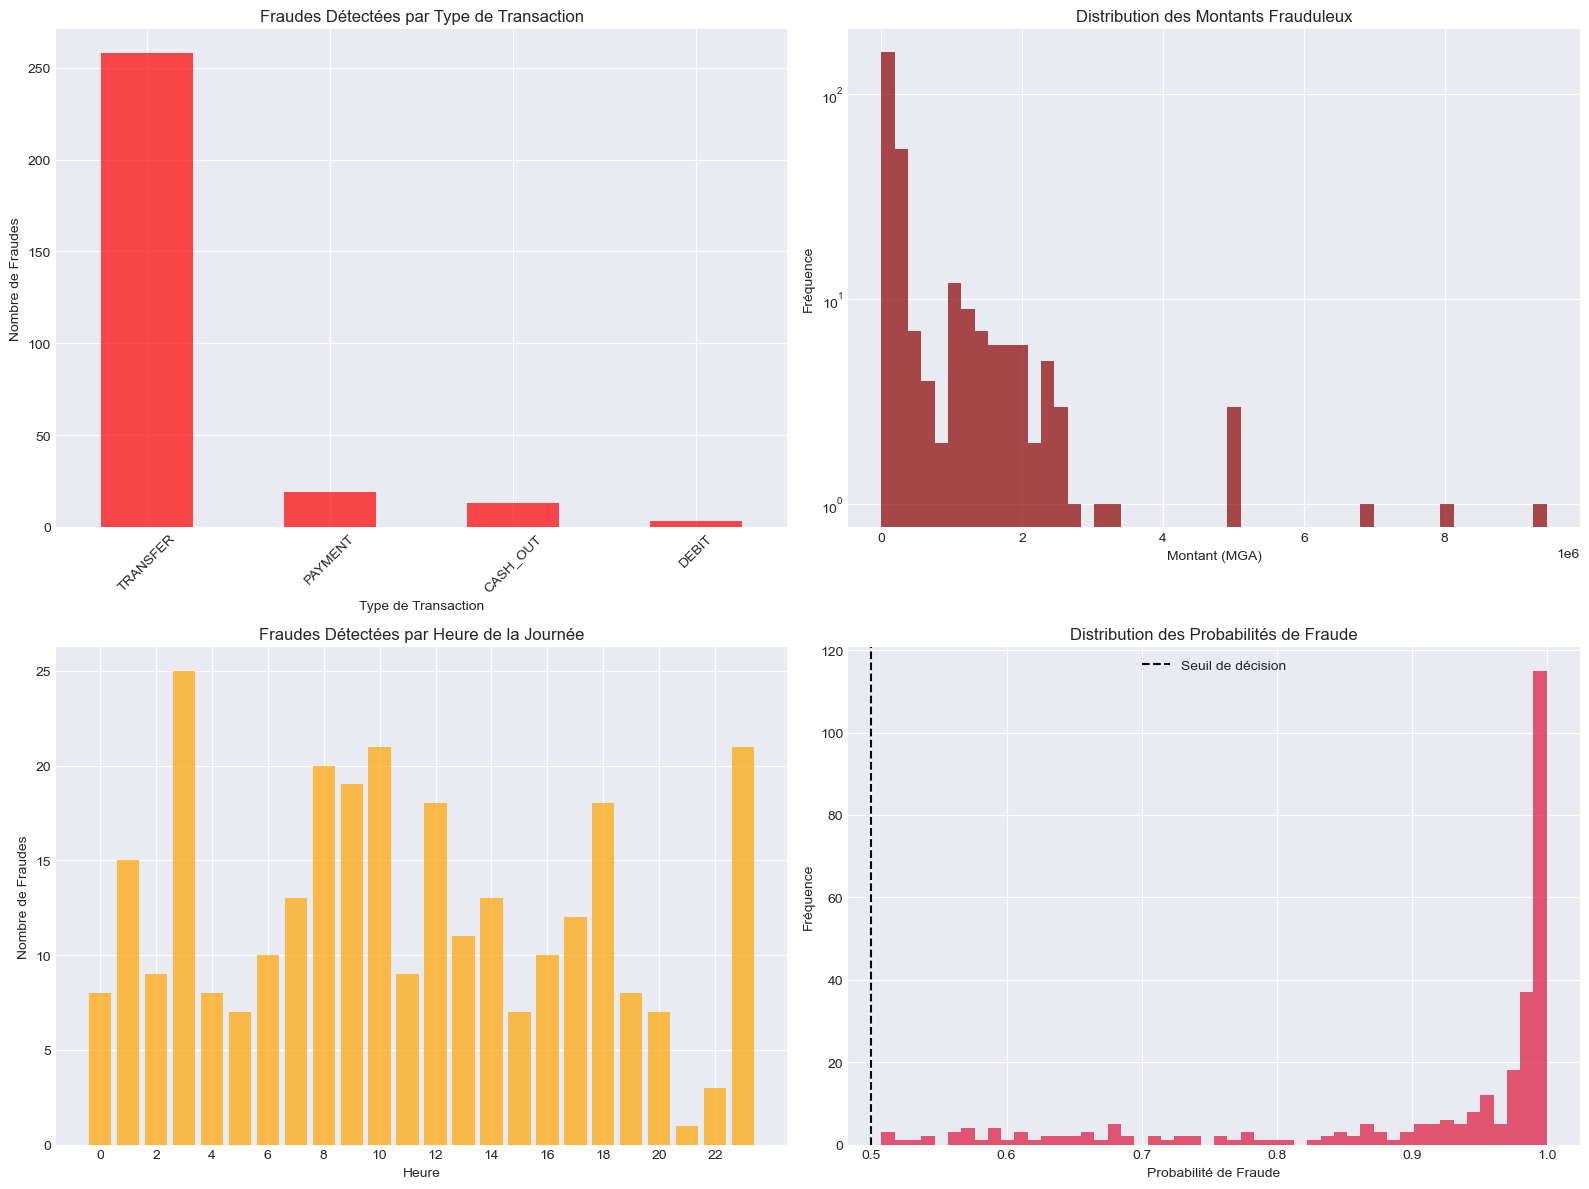

In [86]:
# Visualisations des fraudes détectées
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Répartition par type
fraud_by_type.plot(kind='bar', ax=axes[0, 0], color='red', alpha=0.7)
axes[0, 0].set_title('Fraudes Détectées par Type de Transaction')
axes[0, 0].set_xlabel('Type de Transaction')
axes[0, 0].set_ylabel('Nombre de Fraudes')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Distribution des montants frauduleux
axes[0, 1].hist(detected_frauds['amount'], bins=50, color='darkred', alpha=0.7)
axes[0, 1].set_title('Distribution des Montants Frauduleux')
axes[0, 1].set_xlabel('Montant (MGA)')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].set_yscale('log')

# 3. Fraudes par heure de la journée
fraud_by_hour = detected_frauds.groupby('hour_of_day').size()
axes[1, 0].bar(fraud_by_hour.index, fraud_by_hour.values, color='orange', alpha=0.7)
axes[1, 0].set_title('Fraudes Détectées par Heure de la Journée')
axes[1, 0].set_xlabel('Heure')
axes[1, 0].set_ylabel('Nombre de Fraudes')
axes[1, 0].set_xticks(range(0, 24, 2))

# 4. Distribution des probabilités de fraude
axes[1, 1].hist(detected_frauds['fraud_probability'], bins=50, color='crimson', alpha=0.7)
axes[1, 1].set_title('Distribution des Probabilités de Fraude')
axes[1, 1].set_xlabel('Probabilité de Fraude')
axes[1, 1].set_ylabel('Fréquence')
axes[1, 1].axvline(x=0.5, color='black', linestyle='--', label='Seuil de décision')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 📝 11. Patterns et Insights des Fraudes

In [89]:
print("\n🔍 PATTERNS ET INSIGHTS DES FRAUDES DÉTECTÉES")
print("="*80)

# 1. Analyse temporelle
print("\n⏰ Patterns Temporels:")
night_frauds = detected_frauds[detected_frauds['is_night'] == 1]
weekend_frauds = detected_frauds[detected_frauds['is_weekend'] == 1]
print(f"  - Fraudes nocturnes (0h-6h): {len(night_frauds):,} ({len(night_frauds)/len(detected_frauds)*100:.1f}%)")
print(f"  - Fraudes en weekend: {len(weekend_frauds):,} ({len(weekend_frauds)/len(detected_frauds)*100:.1f}%)")

# 2. Analyse comportementale
print("\n👤 Patterns Comportementaux:")
high_amount_frauds = detected_frauds[detected_frauds['amount'] > detected_frauds['amount'].quantile(0.75)]
print(f"  - Fraudes de montants élevés (>Q3): {len(high_amount_frauds):,} ({len(high_amount_frauds)/len(detected_frauds)*100:.1f}%)")
print(f"  - Montant moyen des fraudes: {detected_frauds['amount'].mean():,.0f} MGA")
print(f"  - Nombre moyen de transactions par client fraudeur: {detected_frauds.groupby('customer_id').size().mean():.1f}")

# 3. Segments d'âge à risque
print("\n👥 Segments d'Âge à Risque:")
fraud_age_dist = detected_frauds.groupby('age_category').size().sort_values(ascending=False)
for age_cat, count in fraud_age_dist.items():
    percent = (count / len(detected_frauds)) * 100
    print(f"  - {age_cat}: {count:,} ({percent:.1f}%)")

# 4. Types de transactions à surveiller
print("\n🎯 Recommandations de Surveillance:")
print("  1. Surveiller particulièrement les transactions de type:", fraud_by_type.index[0])
print("  2. Renforcer les contrôles durant les heures nocturnes (0h-6h)")
print("  3. Mettre en place des alertes pour les montants > 100,000 MGA")
print("  4. Vérifier les transactions répétées d'un même client en peu de temps")


🔍 PATTERNS ET INSIGHTS DES FRAUDES DÉTECTÉES

⏰ Patterns Temporels:
  - Fraudes nocturnes (0h-6h): 72 (24.6%)
  - Fraudes en weekend: 119 (40.6%)

👤 Patterns Comportementaux:
  - Fraudes de montants élevés (>Q3): 73 (24.9%)
  - Montant moyen des fraudes: 612,077 MGA
  - Nombre moyen de transactions par client fraudeur: 1.0

👥 Segments d'Âge à Risque:
  - 18-25: 144 (49.1%)
  - 26-35: 72 (24.6%)
  - 65+: 25 (8.5%)
  - 56-65: 21 (7.2%)
  - 46-55: 17 (5.8%)
  - 36-45: 14 (4.8%)

🎯 Recommandations de Surveillance:
  1. Surveiller particulièrement les transactions de type: TRANSFER
  2. Renforcer les contrôles durant les heures nocturnes (0h-6h)
  3. Mettre en place des alertes pour les montants > 100,000 MGA
  4. Vérifier les transactions répétées d'un même client en peu de temps


## 💾 12. Sauvegarde du Modèle

In [92]:
import pickle

# Sauvegarde du modèle et du scaler
with open('final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✅ Modèle et scaler sauvegardés!")
print("   - final_model.pkl")
print("   - scaler.pkl")

✅ Modèle et scaler sauvegardés!
   - final_model.pkl
   - scaler.pkl


## 🎉 13. Résumé Final

In [95]:
print("\n" + "="*80)
print("🎉 RÉSUMÉ FINAL DU PROJET")
print("="*80)

print(f"\n📊 Données:")
print(f"  - Transactions de train: {len(train_df):,}")
print(f"  - Transactions de test: {len(test_df):,}")
print(f"  - Features créées: {len(X_train.columns)}")

print(f"\n🎯 Performance du Modèle Final ({best_model_name}):")
print(f"  - F1-Score: {best_f1:.4f}")
print(f"  - Precision: {all_results.loc[best_model_idx, 'Val Precision']:.4f}")
print(f"  - Recall: {all_results.loc[best_model_idx, 'Val Recall']:.4f}")
print(f"  - AUC-ROC: {all_results.loc[best_model_idx, 'Val AUC']:.4f}")

print(f"\n🚨 Fraudes Détectées:")
print(f"  - Nombre total: {len(detected_frauds):,}")
print(f"  - Montant total: {detected_frauds['amount'].sum():,.0f} MGA")

print(f"\n📁 Fichiers Générés:")
print(f"  - submission.csv ✅")
print(f"  - final_model.pkl ✅")
print(f"  - scaler.pkl ✅")

print(f"\n🎓 Projet terminé avec succès!")
print("="*80)


🎉 RÉSUMÉ FINAL DU PROJET

📊 Données:
  - Transactions de train: 30,000
  - Transactions de test: 10,000
  - Features créées: 27

🎯 Performance du Modèle Final (XGBoost):
  - F1-Score: 0.7420
  - Precision: 0.6402
  - Recall: 0.8824
  - AUC-ROC: 0.9687

🚨 Fraudes Détectées:
  - Nombre total: 293
  - Montant total: 179,338,500 MGA

📁 Fichiers Générés:
  - submission.csv ✅
  - final_model.pkl ✅
  - scaler.pkl ✅

🎓 Projet terminé avec succès!
